In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Library**

# **Loading Data**

In [3]:
train_Data = "/content/drive/MyDrive/ASL Dataset/train"
test_data = "/content/drive/MyDrive/ASL Dataset/test"

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
import numpy as np
import cv2
minValue = 70
def func(train_data):
    frame = cv2.imread(train_data)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),2)

    th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return res


In [6]:
image_size = (72, 72)
batch_size = 500
train_ds = image_dataset_from_directory(
   "/content/drive/MyDrive/ASL Dataset/train", #-->directory Path
   labels = "inferred", #-->take the labelsname from directory
   label_mode = 'int', #-->assign integer value each and every label
   validation_split = 0.2,#-->spliting the dataset for validation(80%-->taining,20%-->validation)
   subset = "training",
   seed = 123, #-->used for replication
   image_size = image_size,
   batch_size = batch_size,
)

val_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/ASL Dataset/train",
   labels = "inferred",
   label_mode = 'int',
   validation_split = 0.2,
   subset = "validation",
   seed = 123,
   image_size = image_size,
   batch_size = batch_size,
)

Found 19593 files belonging to 36 classes.
Using 15675 files for training.
Found 19593 files belonging to 36 classes.
Using 3918 files for validation.


In [7]:
class_labels = train_ds.class_names
print(class_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [8]:

# Function to convert RGB image to grayscale (black and white)
def rgb_to_black_and_white(image, label):
    # Convert the image to grayscale using luminance method
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Convert train dataset to black and white
train_ds = train_ds.map(rgb_to_black_and_white)

# Convert validation dataset to black and white
val_ds = val_ds.map(rgb_to_black_and_white)


In [ ]:
# iterator = train_ds.as_numpy_iterator().next()
# iterator[0].shape

(500, 72, 72, 1)

In [ ]:
'''test_ds = image_dataset_from_directory(
   "/content/drive/MyDrive/ASL Dataset/test",
   labels = "inferred",
   label_mode = 'int',
   seed = 1337,
   image_size = image_size,
   batch_size = batch_size,
)
'''

# **Visualizing the data**

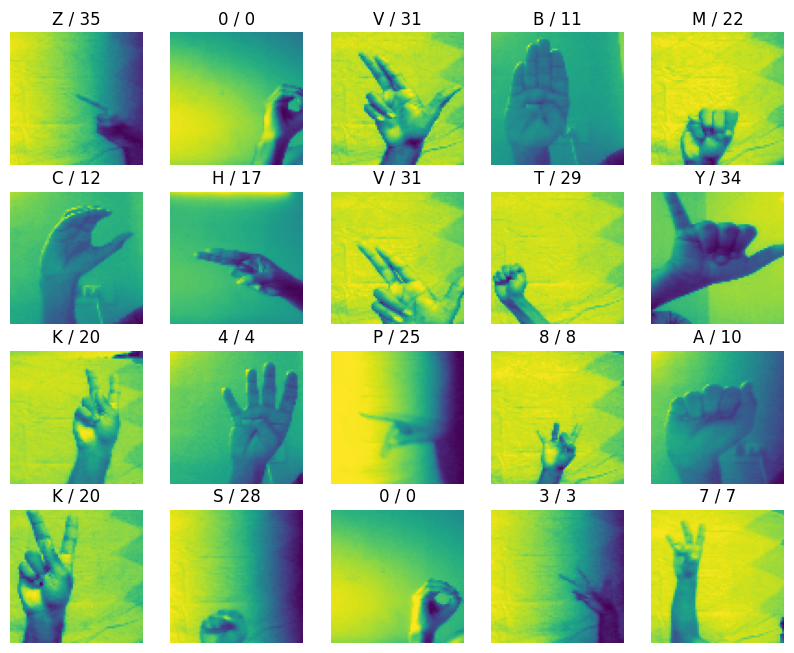

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for image, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image[i])
    plt.axis("off")
    plt.title('{} / {}'.format(class_labels[labels[i]], labels[i]))

# **Augmentating the Images and Preprocessing**
* image rotation
* image Zoom
* image Flip



In [9]:
train_ds = train_ds.map(lambda x,y: (x/255,y))
val_ds = val_ds.map(lambda x,y: (x/255,y))

# augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1,width_factor=0.1),
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
# ])

# train_ds = train_ds.map(lambda x,y: (augmentation(x),y))

# **CNN Model**

In [10]:
# Import necessary libraries
import tensorflow as tf

model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(72, 72, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64,(2,2),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,(2,2),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(36,activation='softmax')  # Adjust the final Dense layer as needed
])


# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])




In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 70, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 35, 35, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 17, 17, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

In [11]:
# Fit the model with adjusted batch size
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    batch_size=batch_size,  # Use the modified batch size
)

Epoch 1/20
32/32 [==============================] - 74s 2s/step - loss: 3.5124 - accuracy: 0.0520 - val_loss: 3.2634 - val_accuracy: 0.0952
Epoch 2/20
32/32 [==============================] - 67s 2s/step - loss: 2.8498 - accuracy: 0.1671 - val_loss: 2.4068 - val_accuracy: 0.2603
Epoch 3/20
32/32 [==============================] - 57s 1s/step - loss: 2.2013 - accuracy: 0.3263 - val_loss: 1.9801 - val_accuracy: 0.3839
Epoch 4/20
32/32 [==============================] - 67s 2s/step - loss: 1.7858 - accuracy: 0.4454 - val_loss: 1.6714 - val_accuracy: 0.4824
Epoch 5/20
32/32 [==============================] - 59s 1s/step - loss: 1.4920 - accuracy: 0.5337 - val_loss: 1.3720 - val_accuracy: 0.5748
Epoch 6/20
32/32 [==============================] - 70s 2s/step - loss: 1.2208 - accuracy: 0.6299 - val_loss: 1.1252 - val_accuracy: 0.6529
Epoch 7/20
32/32 [==============================] - 70s 2s/step - loss: 0.9981 - accuracy: 0.6926 - val_loss: 0.9460 - val_accuracy: 0.6947
Epoch 8/20
32/32 [==

In [14]:
model_json = model.to_json()
with open("/content/drive/MyDrive/signlanguagedetection128x128.json", 'w') as json_file:
  json_file.write(model_json)
model.save("/content/drive/MyDrive/signlanguagedetection128x128.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
